In [1]:
"""
Solutibility-structure Regression for small molecules.
Using the following four types of fingerprints/descriptors:
    -- Morgan fp
    -- RDKit fp
    -- RDKit Descriptors
    -- MACCS Keys
 
Analysis:
    -- Regression fit vs Fingerprint Lengths.
    -- Comparsion of common linear-regression models.
    -- Comparison of different fingerprints predictions.
    -- Assessment of assumptions in linear-regression model.
"""

import os
import numpy as np
import scipy as sp
import pandas as pd
import inspect
from featurizer import featurizer
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem import PandasTools
from collections import OrderedDict
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from best_regularized_models import regularized_models

# Scalers, splitters, and Metrics
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from yellowbrick.regressor import residuals_plot
import statsmodels.api as sm
from utilities import plot_reg, compute_metrics, setup_plot

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

from utilities import plot_style
mpl.rcParams.update(plot_style())
sns.set_palette("tab10")
#cmap = plt.cm.tab20

/usr/local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Reading the Liphophilicty data
esol = pd.read_csv('./data/delaney-processed.csv')
esol.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


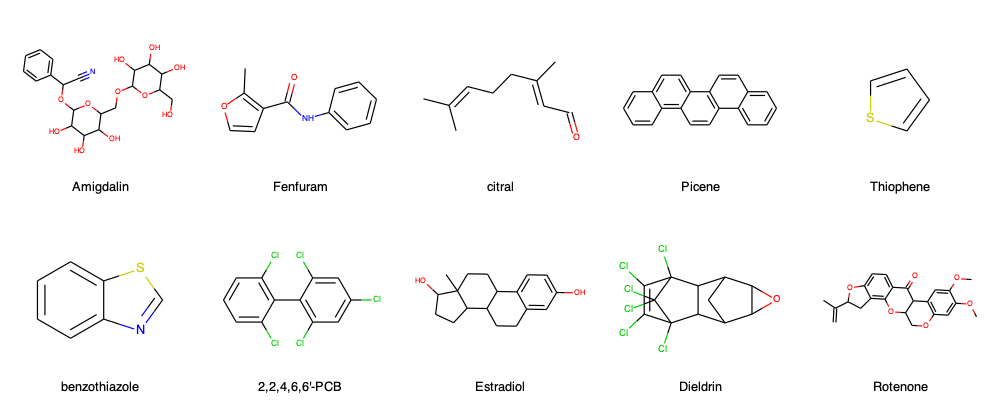

In [3]:
esol['mol'] = esol['smiles'].apply(lambda x: Chem.MolFromSmiles(x))
n_mols = 10
mols = esol['mol'][:n_mols]
lgs=list(esol['Compound ID'][:n_mols].values)
img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200), useSVG=False, legends=lgs )
img

In [4]:
mols = pd.DataFrame(esol['smiles'])
mols.rename(columns = {'smiles': 'SMILES'}, inplace=True)

# featurizer class for generating various features
features = featurizer(mols)
y = esol['ESOL predicted log solubility in mols per litre'].values

In [5]:
# Test Morgan and RDKit fingerprints prediction for various lengths
lengths = [2**i for i in range(5,12)]
columns = pd.MultiIndex.from_product([['Morgan Fingerprint', 'RDKit Fingerprint'], 
                                      ['RMSE', 'R2', 'CV-score']])

results = pd.DataFrame(columns=columns, index=lengths)
results.index.name = 'Fingerprint Length'

for l in lengths:
    df_M = features.get_Morgan_fp(3,l,'M')
    X = df_M[df_M.columns[1:]]
    models = regularized_models(X,y)
    model, cv_score = models.best_Ridge(alphas=np.logspace(-10, -5, 5))
    results.loc[l][:3] = np.hstack((compute_metrics(y, model.predict(X)), -cv_score))
    if(l==lengths[0]): y_smallest_fp = model.predict(X)
    if(l==lengths[-1]): y_largest_fp = model.predict(X)
    
    df_R = features.get_rdkit_fp(3,7,l,'R')
    X = df_R[df_R.columns[1:]]
    models = regularized_models(X,y)
    model, cv_score = models.best_Ridge(alphas=np.logspace(-10, -5, 5))
    results.loc[l][3:] = np.hstack((compute_metrics(y, model.predict(X)), -cv_score))
    
results.head(10)

Morgan fingerprint matrix dimensions:(1128, 32)
RDKit fingerprint matrix dimensions:(1128, 32)
Morgan fingerprint matrix dimensions:(1128, 64)
RDKit fingerprint matrix dimensions:(1128, 64)
Morgan fingerprint matrix dimensions:(1128, 128)
RDKit fingerprint matrix dimensions:(1128, 128)
Morgan fingerprint matrix dimensions:(1128, 256)
RDKit fingerprint matrix dimensions:(1128, 256)
Morgan fingerprint matrix dimensions:(1128, 512)
RDKit fingerprint matrix dimensions:(1128, 512)
Morgan fingerprint matrix dimensions:(1128, 1024)
RDKit fingerprint matrix dimensions:(1128, 1024)
Morgan fingerprint matrix dimensions:(1128, 2048)
RDKit fingerprint matrix dimensions:(1128, 2048)


Morgan Fingerprint                     RDKit Fingerprint  \
                                 RMSE        R2  CV-score              RMSE   
Fingerprint Length                                                            
32                            1.30299  0.400227   1.02165           1.42873   
64                            1.19257  0.497572  0.961364           1.31061   
128                           1.02288  0.630379  0.906013           1.08648   
256                          0.825868  0.759051  0.873156          0.862622   
512                          0.598484  0.873466   1.08341          0.538879   
1024                         0.261878  0.975773   2.14046          0.268955   
2048                         0.186078  0.987768  0.851299          0.273731   

                                        
                          R2  CV-score  
Fingerprint Length                      
32                  0.278882   1.08292  
64                  0.393194   1.02165  
128                  0.58299  0.921105  
256                 0.737128  0.914372  
512                 0.897414   1.12892  
1024                0.974446   2.72434  
2048                 0.97353   1.24548

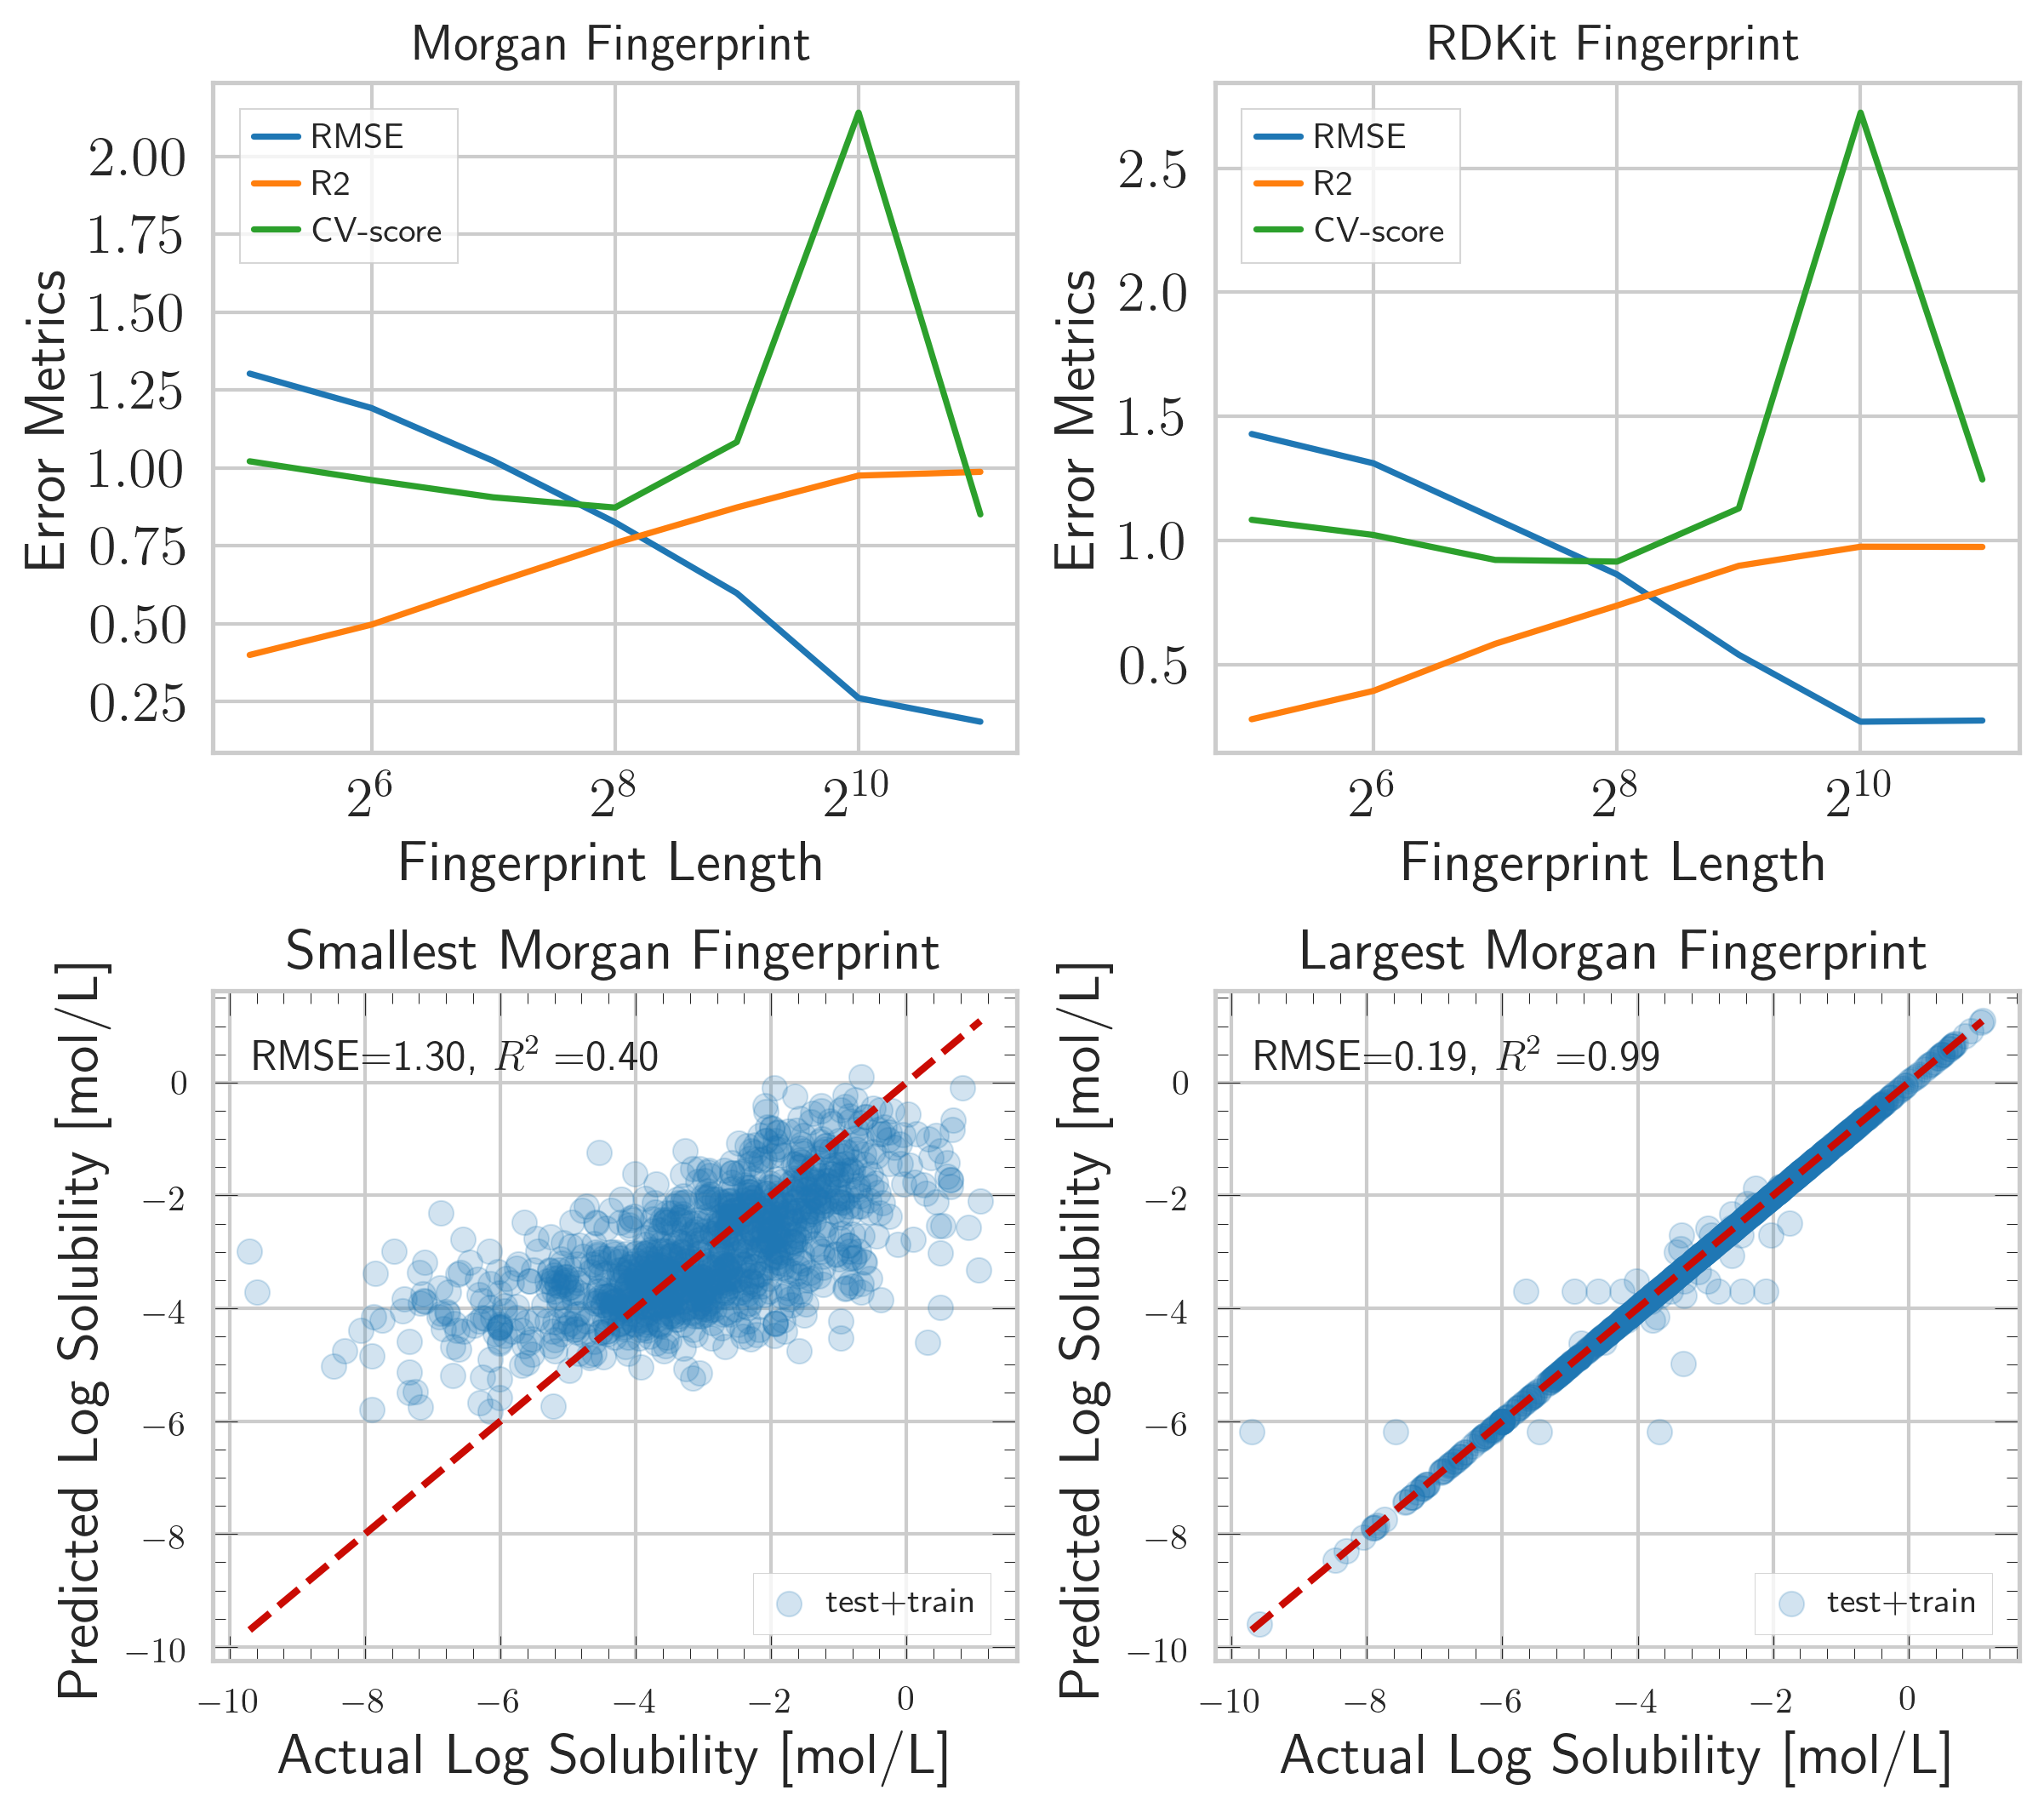

In [6]:
fig, ax = plt.subplots(2,2,figsize=(8,7.2), dpi=300)
i = 0
for keys, group in results.groupby(axis=1, level=0):
    group.columns = group.columns.droplevel()
    group.plot(ax=ax[0][i], title=keys, grid=True, fontsize=16)
    ax[0][i].set_ylabel('Error Metrics', fontsize=16)
    ax[0][i].set_xlabel('Fingerprint Length', fontsize=16)
    ax[0][i].set_xscale('log', basex=2)
    i+=1
   
plot_reg(ax[1][0], 'Smallest Morgan Fingerprint', 'Log Solubility [mol/L]', y, y_smallest_fp)
plot_reg(ax[1][1], 'Largest Morgan Fingerprint', 'Log Solubility [mol/L]', y, y_largest_fp)
fig.tight_layout()

In [7]:
df_M = features.get_Morgan_fp(3,512,'M')
X = df_M[df_M.columns[1:]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
#scaler = StandardScaler().fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

models = regularized_models(X_train,y_train)

Morgan fingerprint matrix dimensions:(1128, 512)


In [9]:
alps = np.logspace(-10, -5, 5)
ests = np.linspace(50, 150, 5)
model_list = {
            'Ridge': models.best_Ridge(alphas=alps)[0],
            'Lasso': models.best_Lasso(alphas=alps)[0],
            'ElasticNet': models.best_ElasticNet(alphas=alps)[0],
            'KernelRidge': models.best_KernelRidge(alphas=alps)[0],
            'RandomForest': models.best_RFRegressor(estimators=ests)[0],
            'GradientBoost': models.best_GBRegressor(estimators=ests)[0],
            }

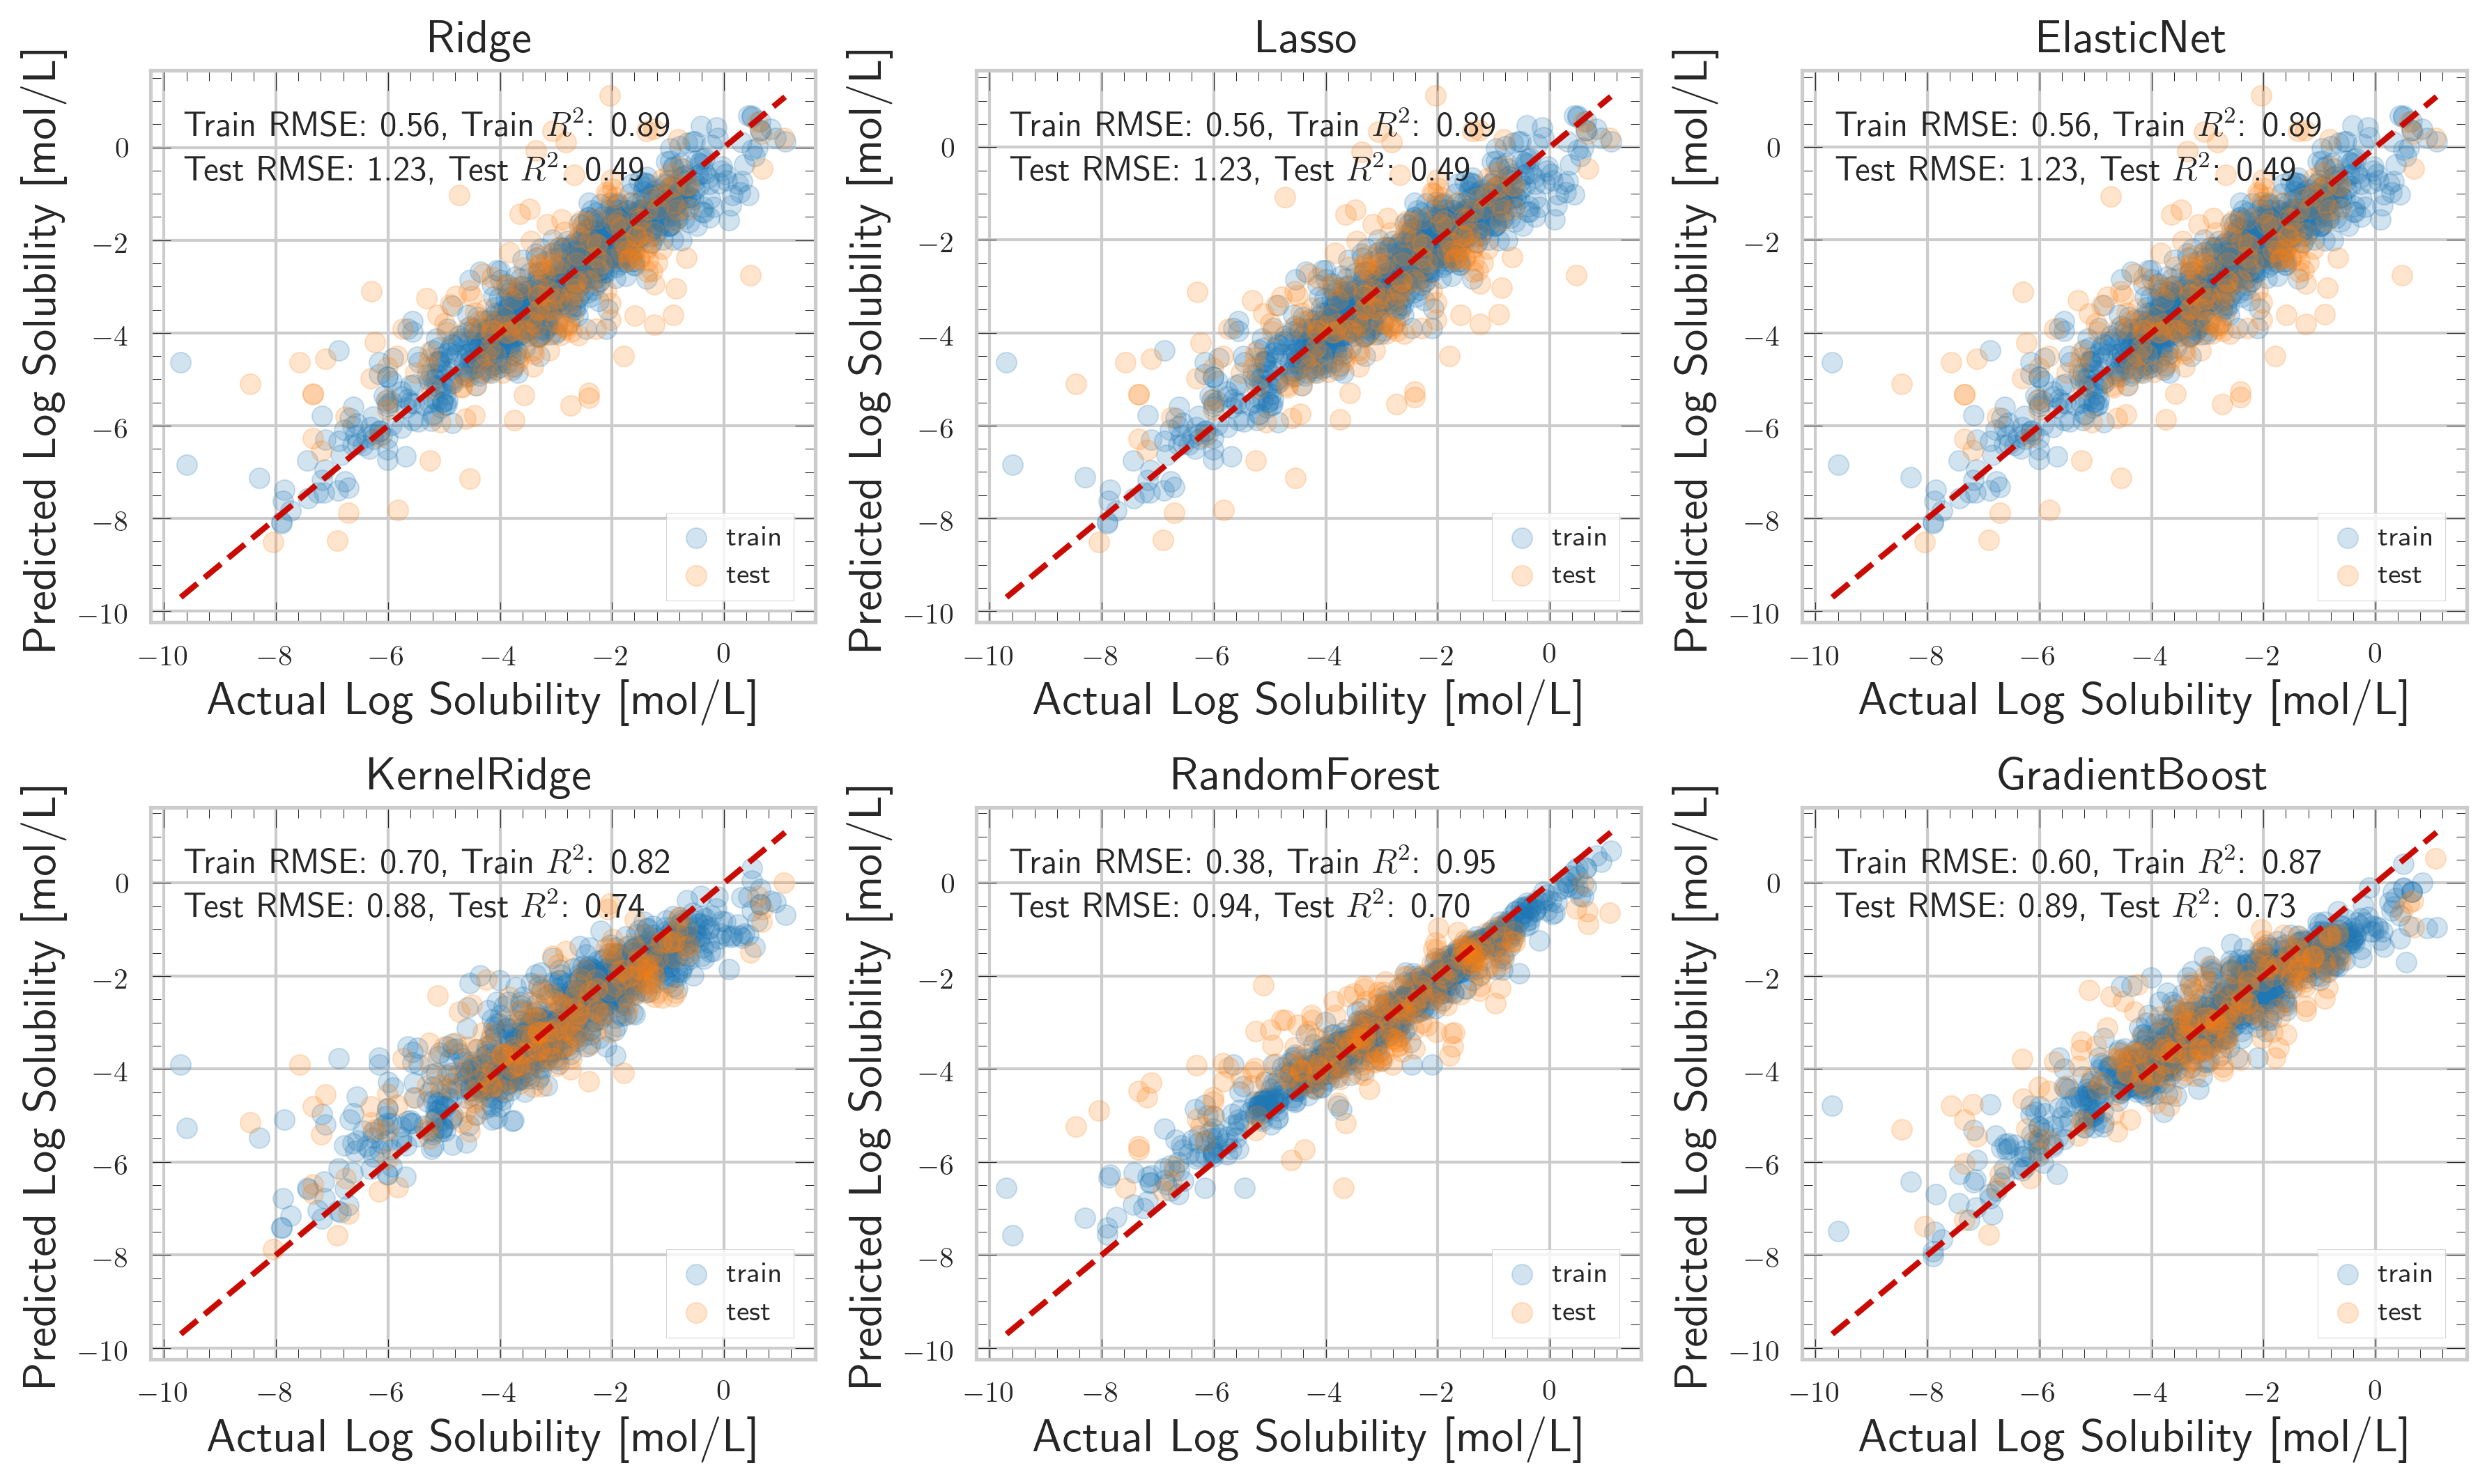

In [14]:
# Comparison of different Regression models
results = pd.DataFrame(columns = ['Train_RMSE', 'Train_R2', 'Test_RMSE', 'Test_R2'])
fig, ax = plt.subplots(2,3,figsize=(12,7.2), dpi=300)
ax = ax.ravel()

for i,model in enumerate(model_list):
    y_train_pred, y_test_pred = model_list[model].predict(X_train), model_list[model].predict(X_test)
    train_rmse, train_r2 = compute_metrics(y_train, y_train_pred)
    test_rmse, test_r2 = compute_metrics(y_test, y_test_pred)
    new_row = pd.Series({'Train_RMSE': train_rmse, 'Train_R2': train_r2, 
                         'Test_RMSE': test_rmse, 'Test_R2': test_r2}, name = model)
    results = results.append(new_row, ignore_index=False)
    plot_reg(ax[i], model, 'Log Solubility [mol/L]', y_train, y_train_pred, y_test, y_test_pred)
    
fig.tight_layout()

In [16]:
results.head(6)

,Train_RMSE,Train_R2,Test_RMSE,Test_R2
Ridge,0.558008,0.888225,1.233895,0.488435
Lasso,0.558020,0.888220,1.227482,0.493738
ElasticNet,0.558018,0.888221,1.227846,0.493438
KernelRidge,0.703152,0.822514,0.883411,0.737777
RandomForest,0.383465,0.947214,0.943473,0.700909
GradientBoost,0.596920,0.872092,0.888573,0.734704


Morgan fingerprint matrix dimensions:(1128, 1024)
RDKit fingerprint matrix dimensions:(1128, 1024)
No. of specific descriptors from RDKIT = 200
No. of MACCS keys:167


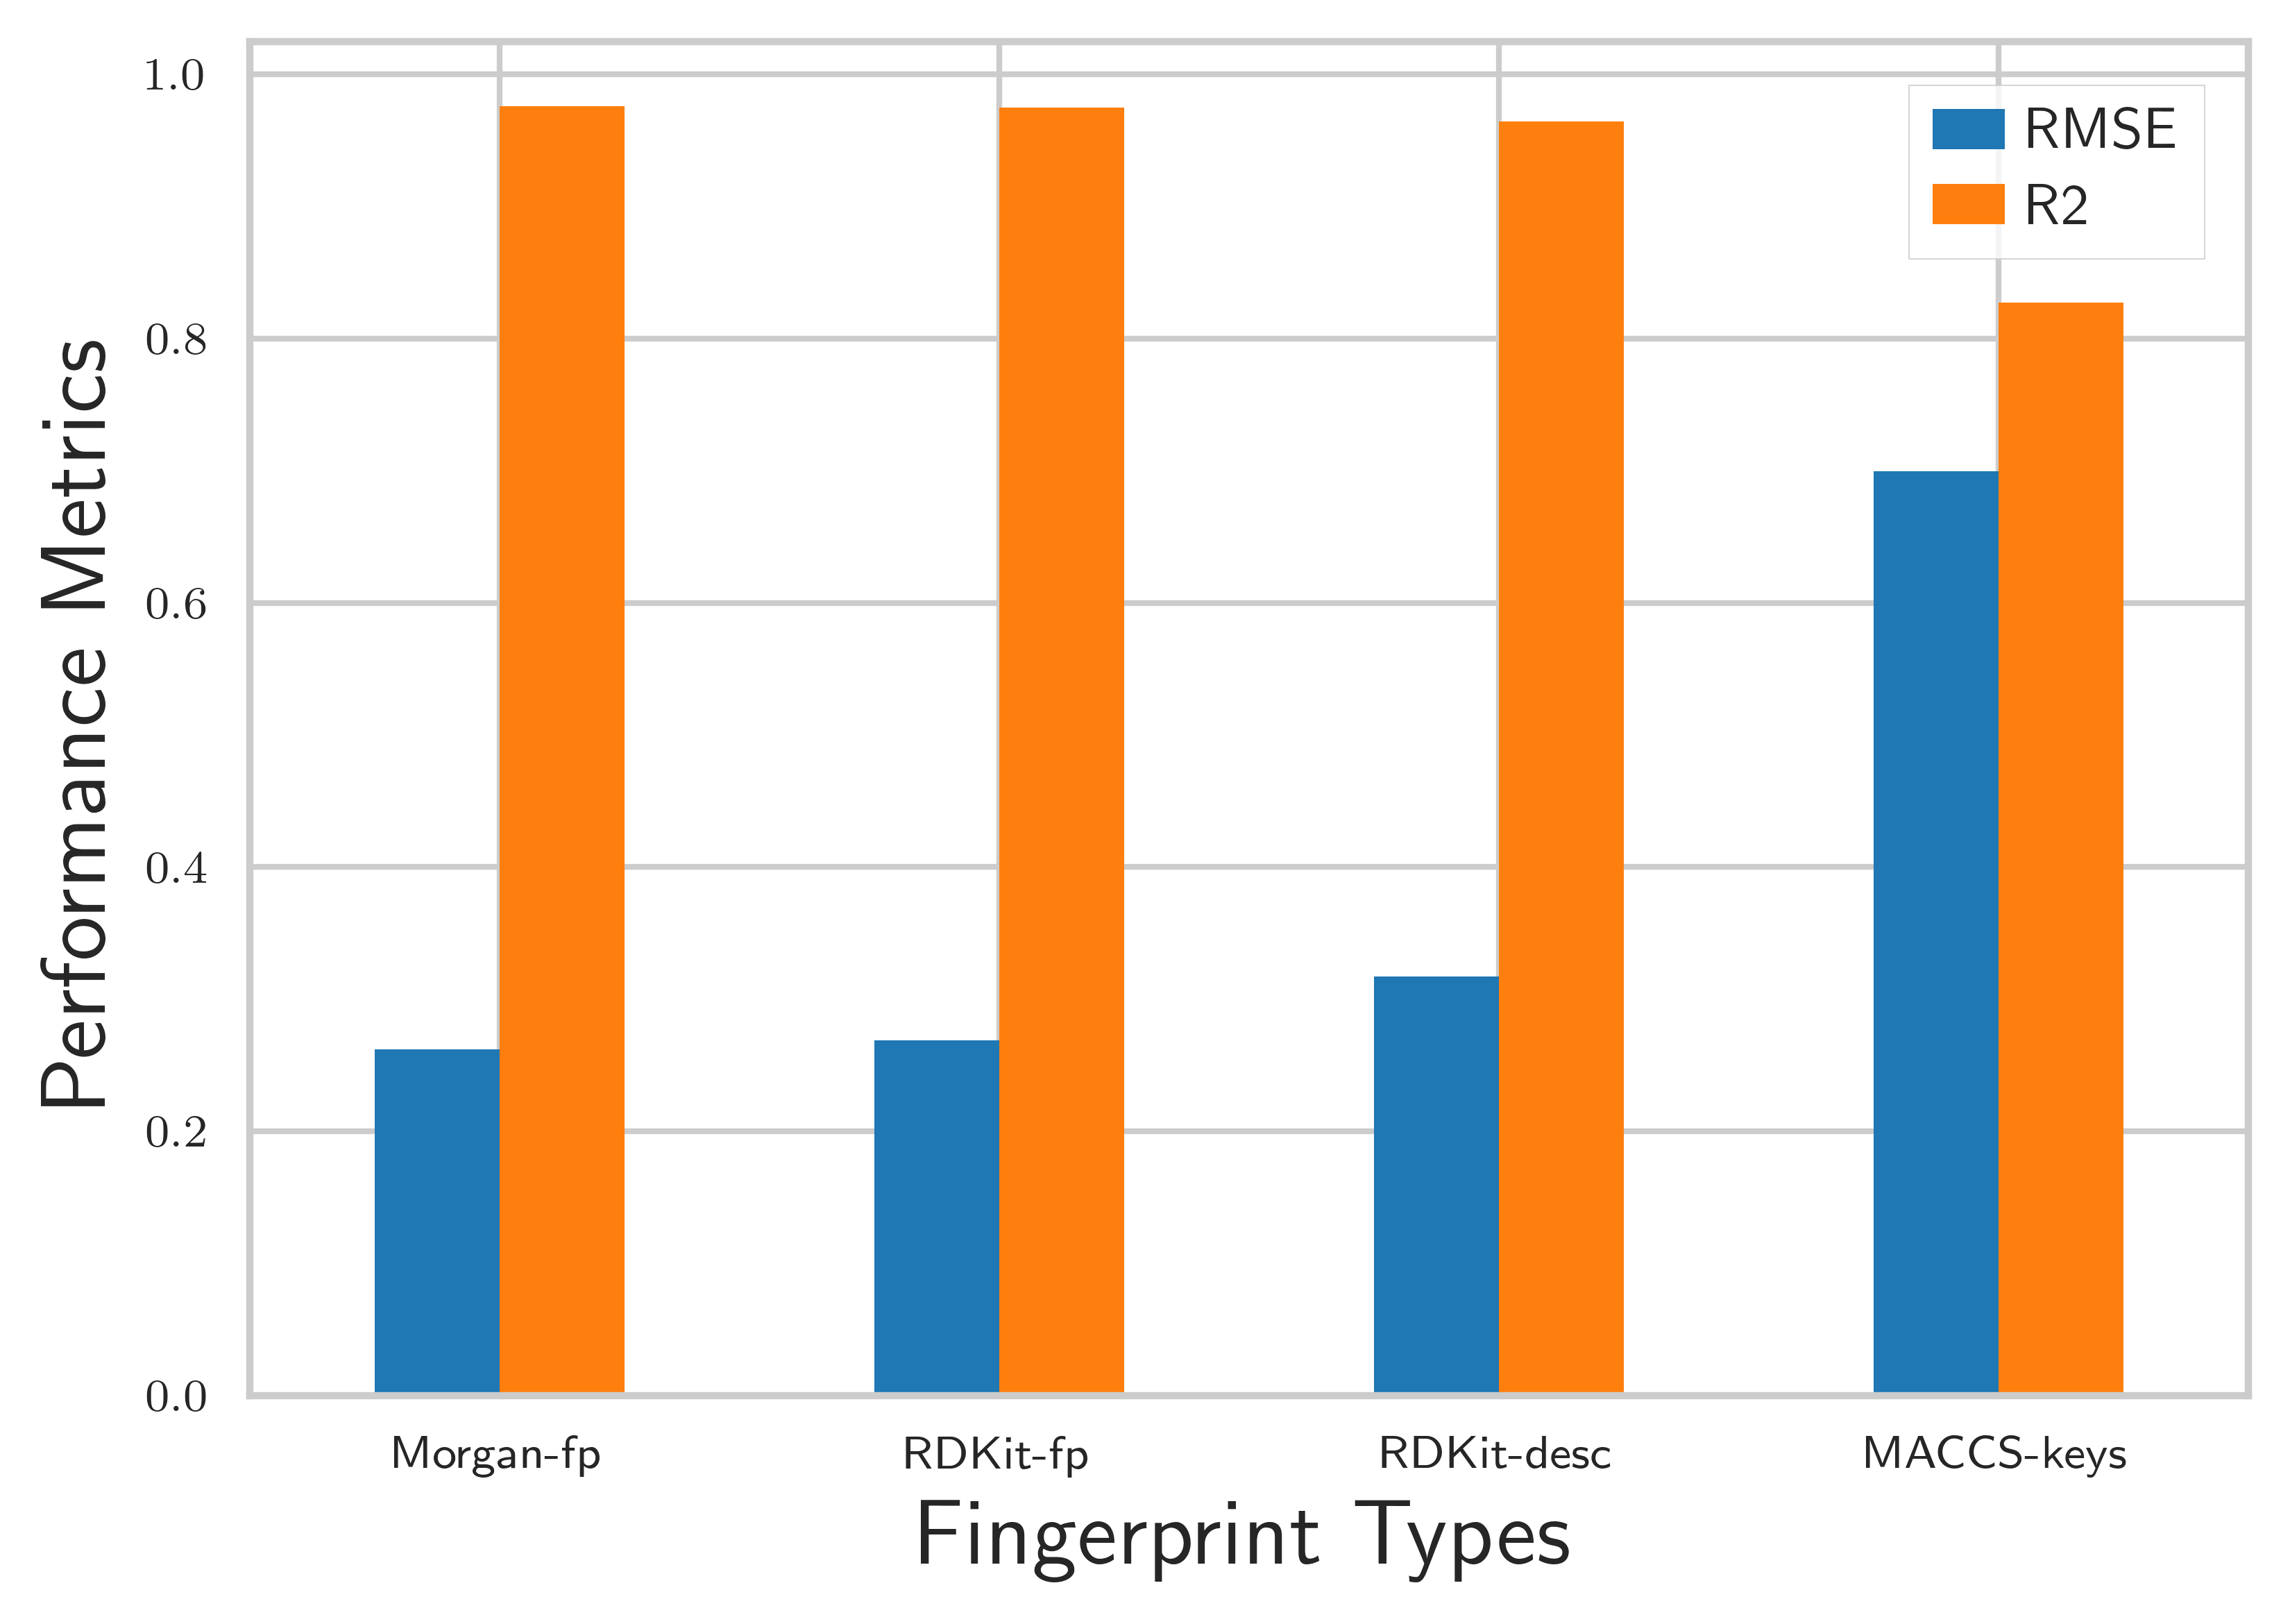

In [17]:
# Compare different feature types
feat_list = {'Morgan-fp': features.get_Morgan_fp(3,1024,'M'),
             'RDKit-fp': features.get_rdkit_fp(3,7,1024,'R'),
             'RDKit-desc': features.get_rdkit_descriptors('RD'),
             'MACCS-keys': features.get_MACCS_fp('MC')
            }

results = pd.DataFrame(columns = ['RMSE', 'R2'])

for feat in feat_list:
    df = feat_list[feat]
    X = df[df.columns[1:]]
    y_pred = regularized_models(X,y).best_Ridge(alphas=alps)[0].predict(X)
    rmse, r2 = compute_metrics(y, y_pred)
    new_row = pd.Series({'RMSE': rmse, 'R2': r2}, name = feat)
    results = results.append(new_row, ignore_index=False)

[fig, ax] = plt.subplots(figsize=(5.6,4), dpi=600)
results.iloc[:,0:2].plot(kind='bar', ax=ax, rot=0, fontsize=8)
lg = ax.legend()
lg.get_frame().set_linewidth(0.25)

plt.xlabel('Fingerprint Types', fontsize=16)
plt.ylabel('Performance Metrics', fontsize=16)
fig.tight_layout()

Morgan fingerprint matrix dimensions:(1128, 512)


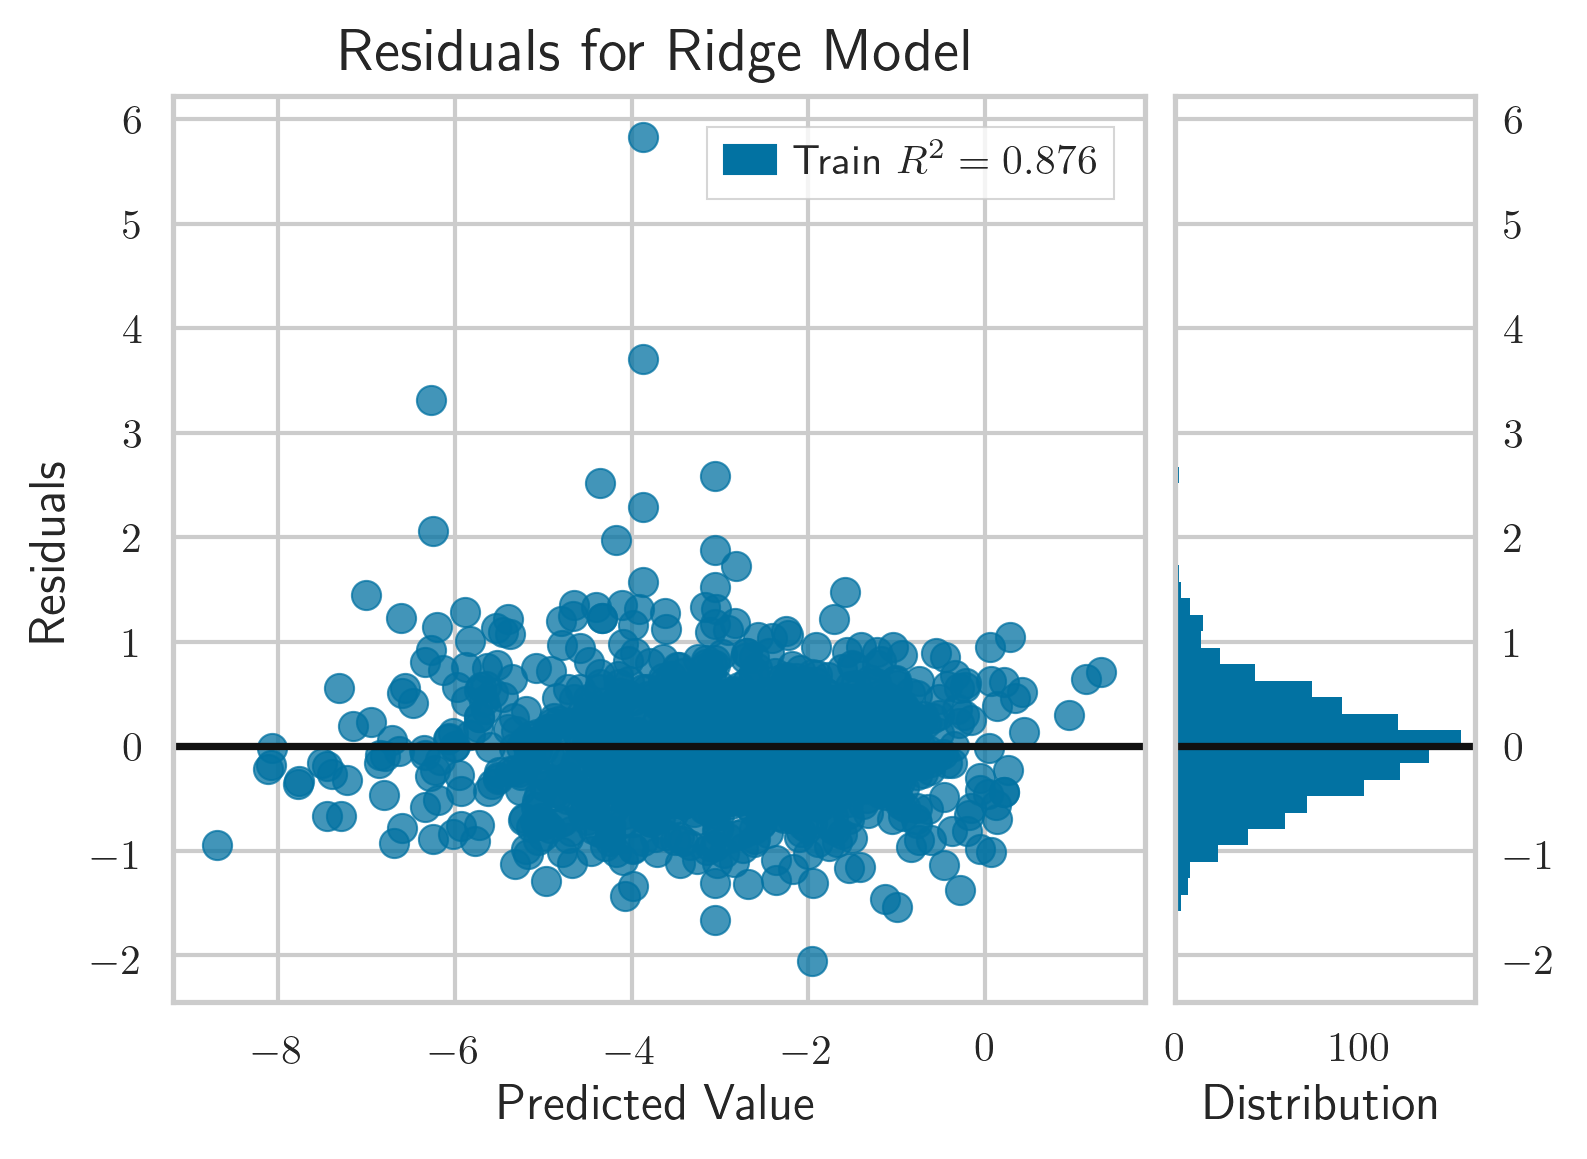

<bound method Figure.tight_layout of <Figure size 1680x1200 with 2 Axes>>

In [18]:
from yellowbrick.regressor.residuals import ResidualsPlot

[fig, ax] = plt.subplots(figsize=(5.6,4), dpi=300)
df = features.get_Morgan_fp(2,512,'M')
X = df[df.columns[1:]]
model = regularized_models(X,y).best_Ridge(alphas=alps)[0]
viz = ResidualsPlot(model,ax=ax).fit(X,y)
viz.show()
fig.tight_layout

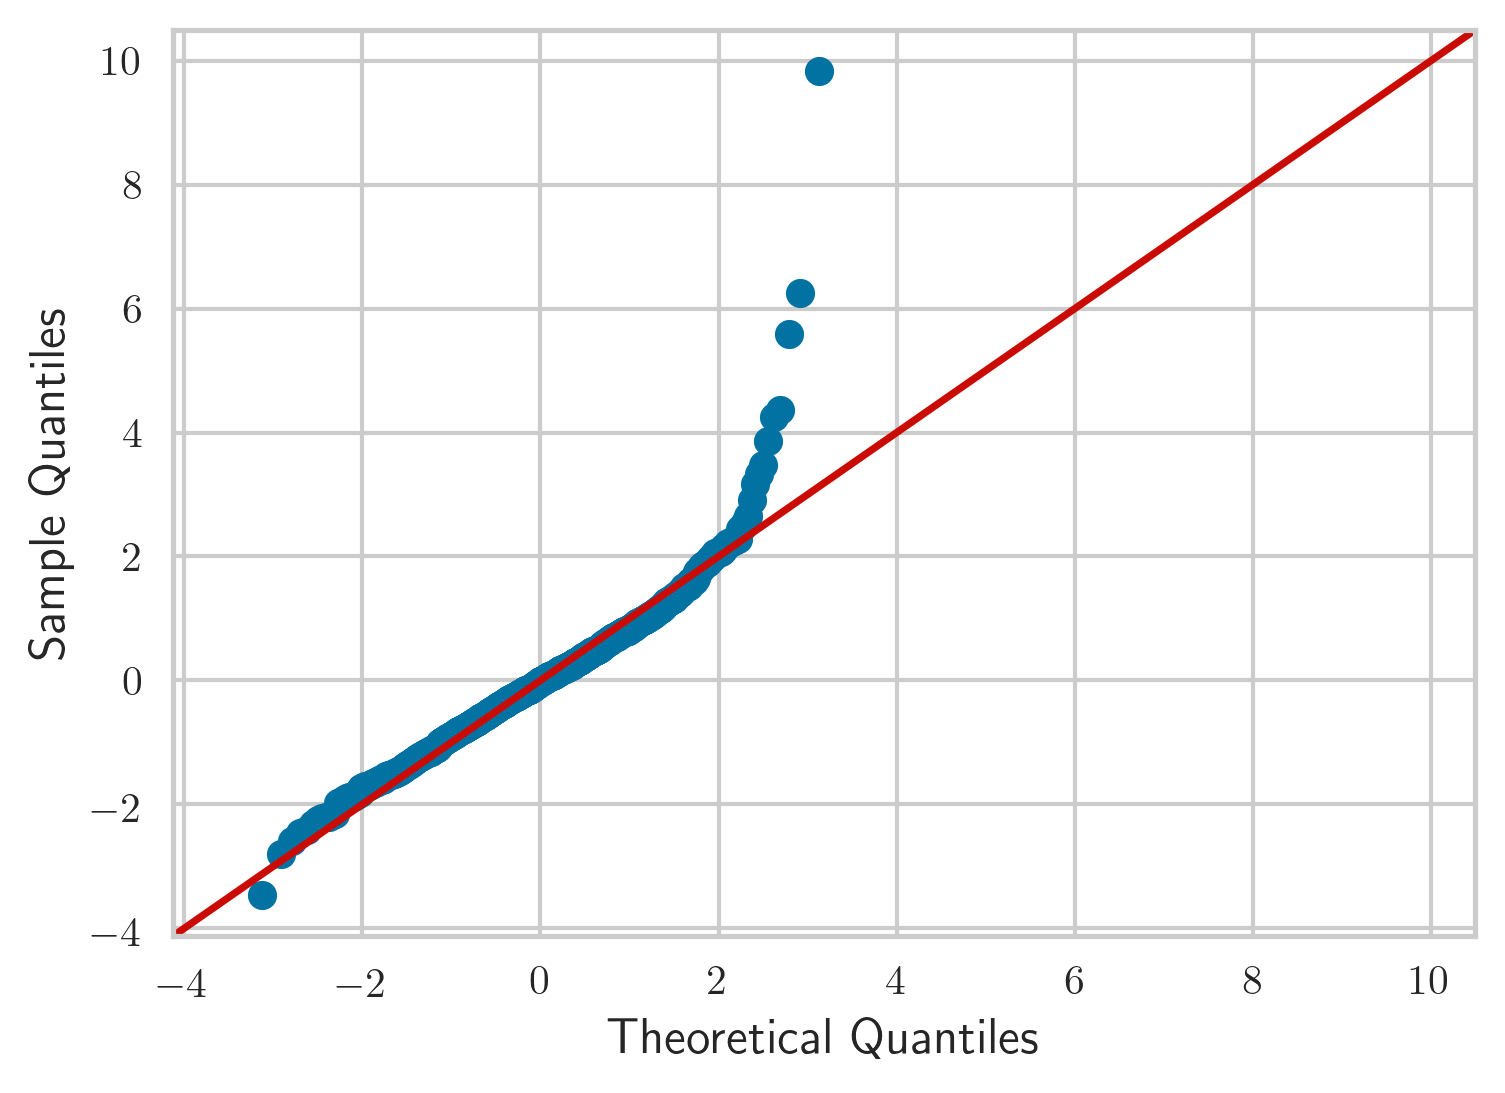

In [19]:
[fig, ax] = plt.subplots(figsize=(5.6,4), dpi=300)
y_pred = model.predict(X)
res = y_pred - y
fig = sm.qqplot(res, fit=True, line='45', ax=ax)